In [1]:
#some changes made to use google colab for model training
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/My\ Drive/ri_project/*.py

import sys
sys.path.append('/content/drive/My Drive/ri_project')

%cd drive/My Drive/ri_project

Mounted at /content/drive
'/content/drive/My Drive/ri_project/OpenSearchSimpleAPI.py'
'/content/drive/My Drive/ri_project/rank_metric.py'
'/content/drive/My Drive/ri_project/TRECCASTeval.py'
/content/drive/My Drive/ri_project


In [2]:
!pip install opensearch-py
!pip install bm25s
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.5/353.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.8 MB/s eta 0:00:00


# Conversational Search Retrieval Augmented Generation

In [3]:
import TRECCASTeval as trec
import numpy as np
import pprint
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import OpenSearchSimpleAPI as osearch
import bm25s
import pandas as pd

nltk.download('stopwords')

pp = pprint.PrettyPrinter(indent=4)


test_bed = trec.ConvSearchEvaluation()


# Initialize stop words and stemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Preprocess text will tokenize the text
This function takes in raw text (usually conversational utterances) and performs the following:

- Converts the text to lowercase.
- Removes non-alphanumeric characters (punctuation, symbols).
- Removes common stopwords using the NLTK stopwords list.
- Stems each word using the Porter stemmer to reduce words to their base forms.

In [4]:

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


### Training and Test Data Processing

Here, we iterate over the training and testing topics provided by the test_bed. We filter out some conversation IDs based on predefined criteria, and then process each utterance in the conversation using our preprocess_text function. The preprocessed utterances are accumulated over turns of the conversation to simulate a growing context.

Key Variables:
- **previous_query_tokenized**: Keeps track of the concatenated previous utterances to simulate a conversation history.
- **topics**: Stores each turn's preprocessed utterances, indexed by a combination of the conversation ID and turn number.

(Printing of the queries is optional and used mostly for debug purposes)


In [5]:

chosen_topic = 77
conversation = {}  # Utilisation d'un dictionnaire
topics = {}

# Regroupement des listes de sujets pertinents
train_topic_ids = {1, 2, 4, 7, 15, 17, 18, 22, 23, 24, 25, 27, 30}
test_topic_ids = {31, 32, 33, 34, 37, 40, 49, 50, 54, 56, 58, 59, 61, 67, 68, 69, 75, 77, 78, 79}

# Regrouper train_topics et test_topics dans une seule itération
for topic_set, valid_ids in [(test_bed.train_topics, train_topic_ids), (test_bed.test_topics, test_topic_ids)]:
    for topic in topic_set:
        conv_id = topic['number']

        # Vérification si le topic est dans les IDs valides
        if conv_id not in valid_ids:
            continue

        previous_query_tokenized = ''
        for turn in topic['turn']:
            turn_id = turn['number']
            utterance = turn['raw_utterance']

            # Construire l'utterance mise à jour
            updated_utterance = previous_query_tokenized + utterance
            previous_query_tokenized += preprocess_text(utterance) + ' '

            # Ajouter à topics
            topic_turn_id = f'{conv_id}_{turn_id}'
            topics[topic_turn_id] = updated_utterance

            # Si c'est le chosen_topic, ajouter au dictionnaire conversation
            if conv_id == chosen_topic:
                conversation[f'{conv_id}_{turn_id}'] = {
                    "conv_id": conv_id,
                    "turn_id": turn_id,
                    "utterance": utterance
                }

# Exemple d'utilisation d'OpenSearch
opensearch = osearch.OSsimpleAPI()
print(conversation)



{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'kwiz': {'settings': {'index': {'creation_date': '1728153198145',
                                 'knn': 'true',
                                 'number_of_replicas': '0',
                                 'number_of_shards': '1',
                                 'provided_name': 'kwiz',
                                 'refresh_interval': '-1',
                                 'similarity': {'default': {'lambda': '0.7',
                                                            'type': 'LMJelinekMercer'}},
                                 'uuid': 'qkpQ7pcwS7iT1IOTsfwRNg',
                                 'version': {'created': '135238227'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'kwiz': {'mappings': {'properties': {'collection': {'type': 'keyword'},
                   

In [6]:

def BM_retrieval(k, topic_conversation):
    #metrics_df = pd.DataFrame(columns=['turn', 'query', '_id'])
    BM25data = []
    bm25_doc_ids = []
    for key, element in topic_conversation.items():
        topic = str(chosen_topic)
        turn = str(element['turn_id'])
        utterance = topic + '_' + turn

        query = topics[utterance]
        print(query)
        opensearch_results = opensearch.search_body(query, numDocs = k)
        best_docs = []
        best_passages = []
        content_to_id = {}
        for index, row in opensearch_results.iterrows():
            doc_id = row['_id']
            doc_body = opensearch.get_doc_body(doc_id)
            best_passages.append(doc_body)
            best_docs.append(doc_id)
            content_to_id[doc_body] = doc_id
        bm25_doc_ids.append([content_to_id[doc] for doc in best_passages if doc in content_to_id])


        BM25data.append({'turn': turn, 'query': element["utterance"], 'expanded_query' : query, 'top passages': best_passages, '_id': best_docs})

    df = pd.DataFrame(BM25data)

    return df

bm25_results = BM_retrieval(k = 100, topic_conversation = conversation)


What's the difference between soup and stew?
what differ soup stew Is chilli a stew?
what differ soup stew chilli stew How about goulash?
what differ soup stew chilli stew goulash What are popular ones in France?
what differ soup stew chilli stew goulash popular one franc How is cassoulet made?
what differ soup stew chilli stew goulash popular one franc cassoulet made Tell me about feijoada and its significance.
what differ soup stew chilli stew goulash popular one franc cassoulet made tell feijoada signific How is it similar or different from cassoulet?
what differ soup stew chilli stew goulash popular one franc cassoulet made tell feijoada signific similar differ cassoulet Tell about Bigos stew.
what differ soup stew chilli stew goulash popular one franc cassoulet made tell feijoada signific similar differ cassoulet tell bigo stew Why is it important?
what differ soup stew chilli stew goulash popular one franc cassoulet made tell feijoada signific similar differ cassoulet tell bigo s

We had the idea of implementing an inverted_index, but it was too heavy to execute and useless xith the provided values in the OpenSearch API.

In [7]:
# inverted_index = []

# def create_inverted_index(doc_ids):
#     inverted_index = {}

#     for doc_id in doc_ids:
#         term_vectors = opensearch.termvectors_JSON(doc_id)

#         # Extract the terms and add them to the inverted index
#         if 'terms' in term_vectors['term_vectors']['contents']:
#             terms = term_vectors['term_vectors']['contents']['terms']
#             for term, stats in terms.items():
#                 if term not in inverted_index:
#                     inverted_index[term] = []
#                 inverted_index[term].append(doc_id)

#     return inverted_index



# for index, row in bm25_results.iterrows():
#     doc_ids = row['_id']
#     turn = row['turn']

#     term_vectors = create_inverted_index( doc_ids)
#     print(term_vectors)
#     inverted_index.append(term_vectors)

# inverted_df = pd.DataFrame(inverted_index)


In [8]:
import pandas as pd

def compute_mu(doc):
    doc_term_vectors = opensearch.doc_term_vectors(doc)
    up = doc_term_vectors[2]
    down = doc_term_vectors[0]

    mu = (0.1 * up) / down
    return mu

def LMD_score(doc, mu, query_terms):
    LMD = 1
    doc_term_vectors = opensearch.doc_term_vectors(doc)
    index = doc_term_vectors[3]


    for term in query_terms:
        if term in index:

            term_freq = index[term][0]
            doc_freq = index[term][1]
            ttf = index[term][2]


            up_term = term_freq + int(mu) * (ttf / doc_term_vectors[2])
            down_term = doc_term_vectors[1] + mu

            qt = query_terms.count(term)

            if up_term != 0 and down_term != 0:

                LMD *= (up_term / down_term) ** qt

    return LMD


results = []

for index, row in bm25_results.iterrows():
    doc_ids = row['_id']
    turn = row['turn']
    expanded_query = row['expanded_query']

    print(expanded_query)


    query_terms = expanded_query.split()

    print(turn)
    print("-------------------------------------------------------")


    scores = {}


    for doc in doc_ids:
        mu = compute_mu(doc)
        LMD_score_doc = LMD_score(doc, mu, query_terms)
        scores[doc] = LMD_score_doc


    sorted_docs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    top_N_docs = [doc[0] for doc in sorted_docs]

    # Stocker les résultats dans la liste
    results.append({
        'turn': turn,
        'query': expanded_query,
        'top_N_docs': top_N_docs
    })

results_df = pd.DataFrame(results)

print(results_df)


What's the difference between soup and stew?
1
-------------------------------------------------------
what differ soup stew Is chilli a stew?
2
-------------------------------------------------------
what differ soup stew chilli stew How about goulash?
3
-------------------------------------------------------
what differ soup stew chilli stew goulash What are popular ones in France?
4
-------------------------------------------------------
what differ soup stew chilli stew goulash popular one franc How is cassoulet made?
5
-------------------------------------------------------
what differ soup stew chilli stew goulash popular one franc cassoulet made Tell me about feijoada and its significance.
6
-------------------------------------------------------
what differ soup stew chilli stew goulash popular one franc cassoulet made tell feijoada signific How is it similar or different from cassoulet?
7
-------------------------------------------------------
what differ soup stew chilli stew

In [9]:
turns_BM = []
BM_ap_values = []
BM_ndcg_values = []
BM_precision_values = []
BM_recall_values = []

print("BM25")

for index, row in bm25_results.iterrows():
    try:

        turn = f"{chosen_topic}_{row['turn']}"
        query = row['query']
        docs = row['_id']

        result_df = pd.DataFrame({"_id": docs})

        p10, recall, ap, ndcg5 = test_bed.eval(result_df, turn)
        turns_BM.append(turn)
        BM_ap_values.append(ap)
        BM_ndcg_values.append(ndcg5)
        BM_precision_values.append(p10)
        BM_recall_values.append(recall)


        print(f"Turn: {turn}")


        print(f"P@10: {p10}, Recall: {recall}, AP: {ap}, NDCG@5: {ndcg5}\n")

    except Exception as e:

        print(f"Erreur sur le tour {turn}: {e}")
        break

print(turns_BM,BM_ap_values,BM_ndcg_values,BM_precision_values, BM_recall_values)


BM25
Turn: 77_1
P@10: 0.8, Recall: 0.6153846153846154, AP: 0.35366162517942523, NDCG@5: 0.6215431670303851

Turn: 77_2
P@10: 0.0, Recall: 0.2, AP: 0.002150537634408602, NDCG@5: 0.0

Turn: 77_3
P@10: 1.0, Recall: 0.7948717948717948, AP: 0.6093518121885131, NDCG@5: 0.91172809177877

Turn: 77_4
P@10: 0.0, Recall: 0.25, AP: 0.01251605655533558, NDCG@5: 0.0

Turn: 77_5
P@10: 0.0, Recall: 0.1388888888888889, AP: 0.008396951250587453, NDCG@5: 0.0

Turn: 77_6
P@10: 0.1, Recall: 0.45, AP: 0.10590742305386128, NDCG@5: 0.09637771110074017

Turn: 77_7
P@10: 0.1, Recall: 0.5714285714285714, AP: 0.12287022093071924, NDCG@5: 0.15979138559512832

Turn: 77_8
P@10: 0.0, Recall: 0.25, AP: 0.019106507605008642, NDCG@5: 0.0

Erreur sur le tour 77_9: Relevance score length < k
['77_1', '77_2', '77_3', '77_4', '77_5', '77_6', '77_7', '77_8'] [0.35366162517942523, 0.002150537634408602, 0.6093518121885131, 0.01251605655533558, 0.008396951250587453, 0.10590742305386128, 0.12287022093071924, 0.019106507605008642

/content/drive/My Drive/ri_project/TRECCASTeval.py:68: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.size(true_pos) / total_relevant


In [10]:

print("LMD")

turns_LMD = []
LMD_ap_values = []
LMD_ndcg_values = []
LMD_precision_values = []
LMD_recall_values = []

for index, row in results_df.iterrows():
    try:

        turn = f"77_{row['turn']}"
        query = row['query']
        docs = row['top_N_docs']

        result_df = pd.DataFrame({"_id": docs})

        p10, recall, ap, ndcg5 = test_bed.eval(result_df, turn)
        turns_LMD.append(turn)
        LMD_ap_values.append(ap)
        LMD_ndcg_values.append(ndcg5)
        LMD_precision_values.append(p10)
        LMD_recall_values.append(recall)


        print(f"Turn: {turn}")


        print(f"P@10: {p10}, Recall: {recall}, AP: {ap}, NDCG@5: {ndcg5}\n")

    except Exception as e:

        print(f"Erreur sur le tour {turn}: {e}")
        break

print(turns_LMD,LMD_ap_values,LMD_ndcg_values,LMD_precision_values, LMD_recall_values)


LMD
Turn: 77_1
P@10: 0.4, Recall: 0.6153846153846154, AP: 0.16500954930312148, NDCG@5: 0.05138956148956205

Turn: 77_2
P@10: 0.0, Recall: 0.2, AP: 0.002666666666666667, NDCG@5: 0.0

Turn: 77_3
P@10: 0.7, Recall: 0.7948717948717948, AP: 0.40766995978888243, NDCG@5: 0.2371988235209051

Turn: 77_4
P@10: 0.2, Recall: 0.25, AP: 0.07940496514440176, NDCG@5: 0.32190282254058966

Turn: 77_5
P@10: 0.0, Recall: 0.1388888888888889, AP: 0.005745530945597615, NDCG@5: 0.0

Turn: 77_6
P@10: 0.1, Recall: 0.45, AP: 0.06151407592231879, NDCG@5: 0.048188855550370086

Turn: 77_7
P@10: 0.2, Recall: 0.5714285714285714, AP: 0.11522191784493437, NDCG@5: 0.12663167705327652

Turn: 77_8
P@10: 0.3, Recall: 0.25, AP: 0.1327585791401581, NDCG@5: 0.5864224010106703

Erreur sur le tour 77_9: Relevance score length < k
['77_1', '77_2', '77_3', '77_4', '77_5', '77_6', '77_7', '77_8'] [0.16500954930312148, 0.002666666666666667, 0.40766995978888243, 0.07940496514440176, 0.005745530945597615, 0.06151407592231879, 0.11522

/content/drive/My Drive/ri_project/TRECCASTeval.py:68: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.size(true_pos) / total_relevant


In [11]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(turns_LMD, LMD_ap_values, marker='o', label='LMD', alpha=0.7)
plt.scatter(turns_LMD, BM_ap_values, marker='x', label='BM25', alpha=0.7)
plt.title("Evolution of AP for each turn")
plt.xlabel("Turns")
plt.ylabel("Scores")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
#plt.show()
plt.savefig("AP.png")
plt.close()




plt.figure(figsize=(10, 6))
plt.scatter(turns_LMD, LMD_ndcg_values, marker='o', label='LMD', alpha=0.7)
plt.scatter(turns_LMD, BM_ndcg_values, marker='x', label='BM25', alpha=0.7)
plt.title("Evolution of NCDG5 for each turn")
plt.xlabel("Turns")
plt.ylabel("Scores")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
#plt.show()
plt.savefig("NCDG5.png")
plt.close()


plt.figure(figsize=(10, 6))
plt.plot(LMD_recall_values, LMD_precision_values, marker='o', label='LMD', alpha=0.7)
plt.plot(BM_recall_values, BM_precision_values, marker='x', label='BM25', alpha=0.7)
plt.title("Precision/recall curb")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
#plt.show()
plt.savefig("PR.png")
plt.close()




In [12]:
import numpy as np
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
from sentence_transformers import SentenceTransformer, CrossEncoder

import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, BertModel, BertTokenizer
from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [13]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [14]:
# Dual-Encoder
dual_encoder_model = 'sentence-transformers/all-MiniLM-L6-v2'

# Cross-Encoder
cross_encoder_model = 'cross-encoder/ms-marco-MiniLM-L-6-v2'

print("Les modèles ont été chargés avec succès !")

CLS_token = "[CLS]"
SEP_token = "[SEP]"

Les modèles ont été chargés avec succès !


In [15]:
relevant_doc_id = "CAR_e8251fadfe615e31682324728119dff9d81d5e41"
irrelevant_doc_id = "CAR_d5a2cf4a5cd5ff5dccbd4208d432c088b5f945e0"

relevant_doc = opensearch.get_doc_body(relevant_doc_id)
print(relevant_doc)

irrelevant_doc = opensearch.get_doc_body(irrelevant_doc_id)
print(irrelevant_doc)

turn = 1

first_key = list(conversation.keys())[turn-1]
first_value = (list(conversation.values())[turn-1])
first_value = first_value.get("utterance")

print(first_value)



Soups are similar to stews, and in some cases there may not be a clear distinction between the two; however, soups generally have more liquid than stews.
Most Ghanaian side dishes are served with a stew, soup or a spicy condiment made from raw red and green chilies, onions and tomatoes (pepper sauce). Ghanaian stews and soups are quite sophisticated with liberal and delicate use of exotic ingredients, a wide variety of flavours, spices and textures.
What's the difference between soup and stew?


In [16]:
positive_pair = [first_value, relevant_doc]
negative_pair = [first_value, irrelevant_doc]

print(positive_pair)
print(negative_pair)



["What's the difference between soup and stew?", 'Soups are similar to stews, and in some cases there may not be a clear distinction between the two; however, soups generally have more liquid than stews.']
["What's the difference between soup and stew?", 'Most Ghanaian side dishes are served with a stew, soup or a spicy condiment made from raw red and green chilies, onions and tomatoes (pepper sauce). Ghanaian stews and soups are quite sophisticated with liberal and delicate use of exotic ingredients, a wide variety of flavours, spices and textures.']


In [17]:
transformers.logging.set_verbosity_warning()

tokenizer = AutoTokenizer.from_pretrained(cross_encoder_model)
config = AutoConfig.from_pretrained(cross_encoder_model,  output_hidden_states=True, output_attentions=True)
model = AutoModelForSequenceClassification.from_pretrained(
    cross_encoder_model,
    config=config
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [18]:
sentence_a = [positive_pair[0], negative_pair[0]]
sentence_b = [positive_pair[1], negative_pair[1]]

inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)


In [19]:
input_ids = inputs['input_ids']

input_id_list_relevant = input_ids[0].tolist()

input_id_list_irrelevant = input_ids[1].tolist()

input_tokens_list_relevant = tokenizer.convert_ids_to_tokens(input_id_list_relevant)

input_tokens_list_irrelevant = tokenizer.convert_ids_to_tokens(input_id_list_irrelevant)

inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)


In [20]:
with torch.no_grad():
    outputs = model(**inputs)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [21]:
first_layer = 0
last_layer = len(outputs['hidden_states'])

In [22]:
first_layer_embeddings_relevant = outputs['hidden_states'][first_layer][0]
first_layer_embeddings_irrelevant = outputs['hidden_states'][first_layer][1]
last_layer_embeddings_relevant = outputs['hidden_states'][last_layer-1][0]
last_layer_embeddings_irrelevant = outputs['hidden_states'][last_layer-1][1]


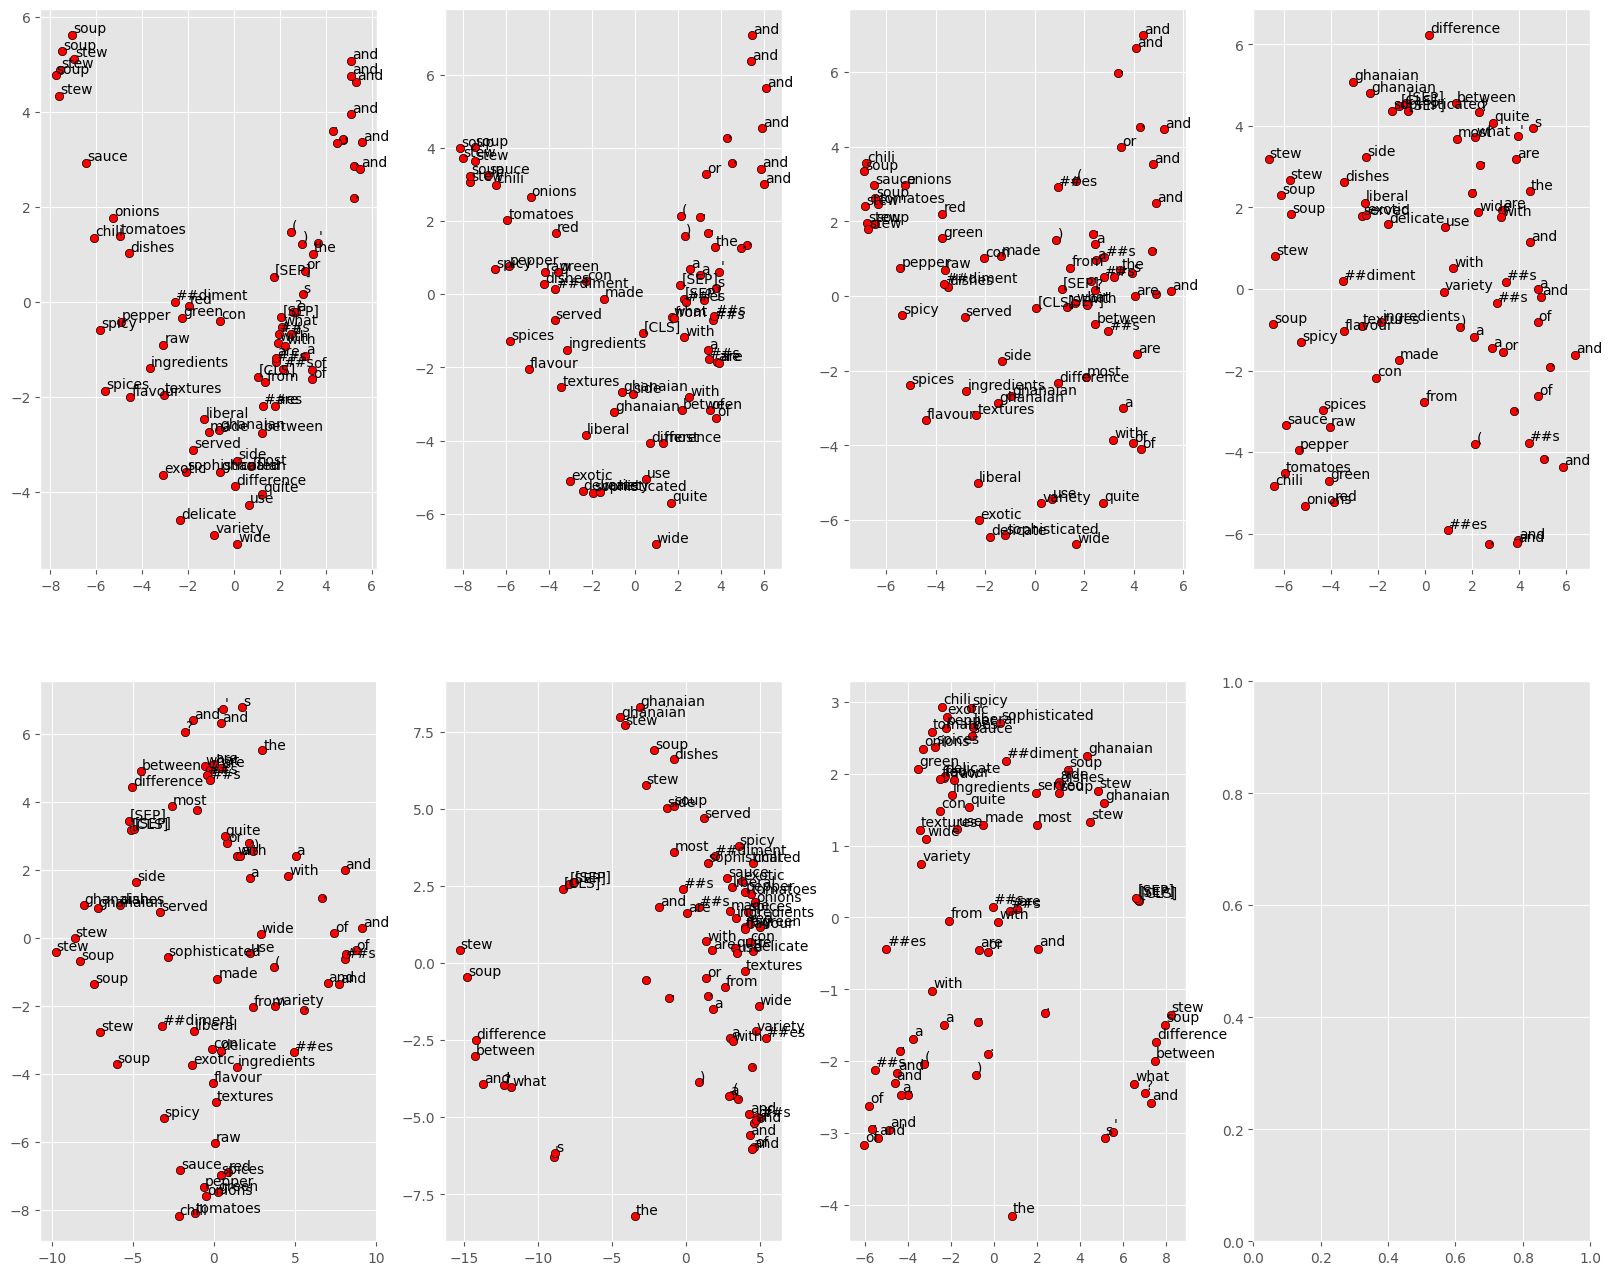

In [23]:
def display_scatterplot(layer_num, layers, words, irrelevant, ax):

    layer_embeddings = layers[layer_num][irrelevant].detach().numpy()

    if layer_embeddings.shape[1] == 2:
        twodim = layer_embeddings
    else:
        pca = PCA()
        pca.fit(layer_embeddings)
        twodim = pca.transform(layer_embeddings)[:,:2]


    ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        ax.text(x+0.05, y+0.05, word)

    return

rows = int(np.ceil(last_layer / 4))
cols = min(last_layer, 4)
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 8))
axes = axes.flatten()



for i in range(last_layer):
    ax = axes[i]
    display_scatterplot(i, outputs['hidden_states'], input_tokens_list_irrelevant, 1, ax)



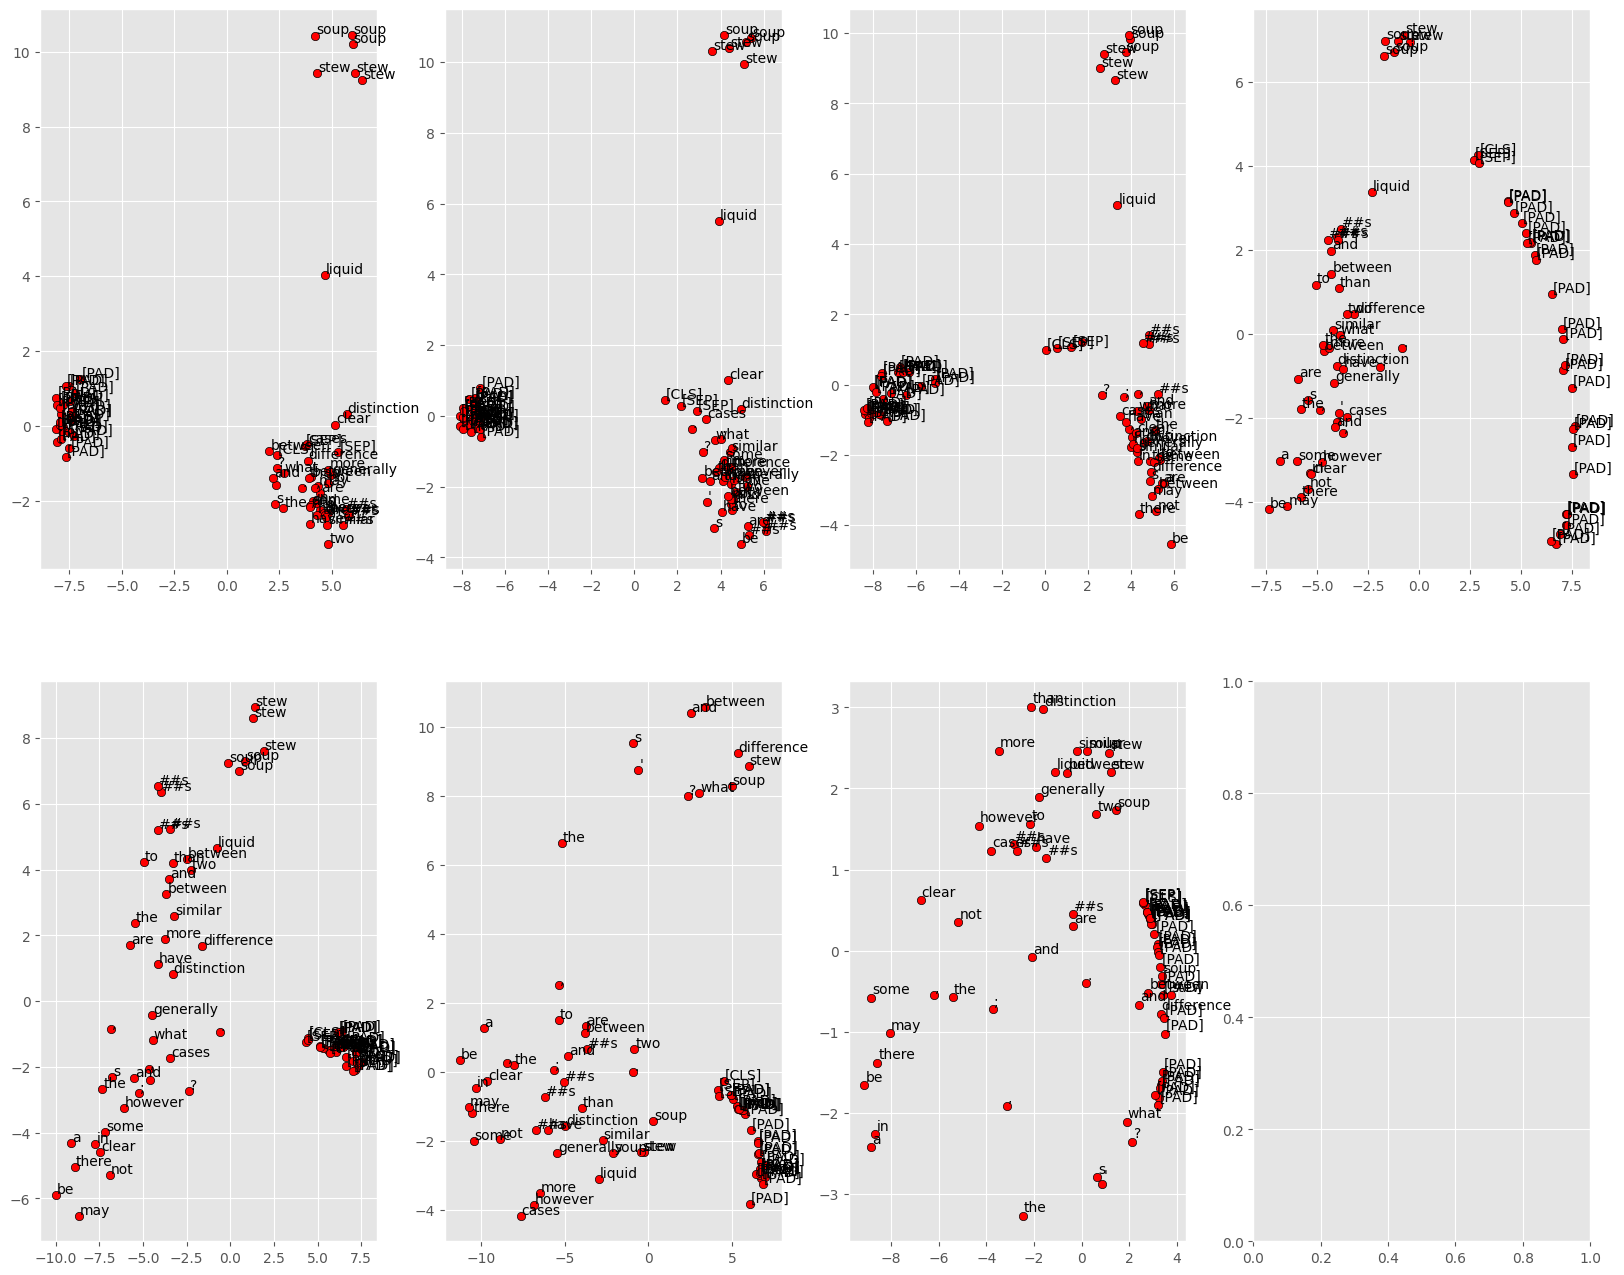

In [24]:
rows = int(np.ceil(last_layer / 4))
cols = min(last_layer, 4)
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 8))
axes = axes.flatten()


for i in range(last_layer):
    ax = axes[i]
    display_scatterplot(i, outputs['hidden_states'], input_tokens_list_relevant, 0, ax)

3

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

query_embedding_first_layer = first_layer_embeddings_relevant.mean(dim=0)
relevant_embedding_first_layer = first_layer_embeddings_relevant.mean(dim=0)
irrelevant_embedding_first_layer = first_layer_embeddings_irrelevant.mean(dim=0)

query_embedding_last_layer = last_layer_embeddings_relevant.mean(dim=0)
relevant_embedding_last_layer = last_layer_embeddings_relevant.mean(dim=0)
irrelevant_embedding_last_layer = last_layer_embeddings_irrelevant.mean(dim=0)

similarity_first_layer_relevant = cosine_similarity(query_embedding_first_layer.unsqueeze(0).cpu().numpy(),
                                                    relevant_embedding_first_layer.unsqueeze(0).cpu().numpy())[0][0]

similarity_first_layer_irrelevant = cosine_similarity(query_embedding_first_layer.unsqueeze(0).cpu().numpy(),
                                                      irrelevant_embedding_first_layer.unsqueeze(0).cpu().numpy())[0][0]

similarity_last_layer_relevant = cosine_similarity(query_embedding_last_layer.unsqueeze(0).cpu().numpy(),
                                                   relevant_embedding_last_layer.unsqueeze(0).cpu().numpy())[0][0]

similarity_last_layer_irrelevant = cosine_similarity(query_embedding_last_layer.unsqueeze(0).cpu().numpy(),
                                                     irrelevant_embedding_last_layer.unsqueeze(0).cpu().numpy())[0][0]

print(f"First Layer - Similarity (Query vs Relevant): {similarity_first_layer_relevant}")
print(f"First Layer - Similarity (Query vs Irrelevant): {similarity_first_layer_irrelevant}")
print(f"Last Layer - Similarity (Query vs Relevant): {similarity_last_layer_relevant}")
print(f"Last Layer - Similarity (Query vs Irrelevant): {similarity_last_layer_irrelevant}")

First Layer - Similarity (Query vs Relevant): 0.9999998211860657
First Layer - Similarity (Query vs Irrelevant): 0.3057100176811218
Last Layer - Similarity (Query vs Relevant): 0.9999997615814209
Last Layer - Similarity (Query vs Irrelevant): 0.7865728139877319


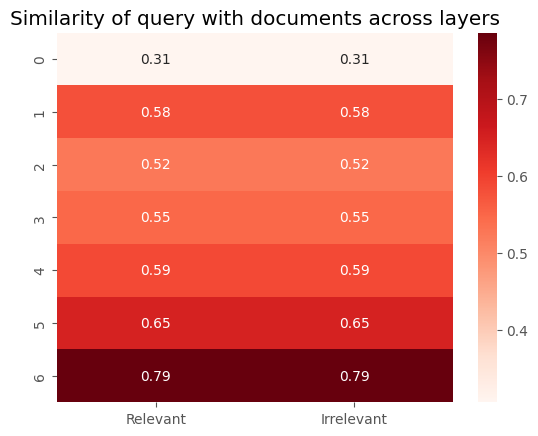

In [26]:
import seaborn as sns
similarity_matrix = []

for layer_idx in range(first_layer, last_layer):
    query_embedding = outputs['hidden_states'][layer_idx][0].mean(dim=0)
    relevant_embedding = outputs['hidden_states'][layer_idx][1].mean(dim=0)
    irrelevant_embedding = outputs['hidden_states'][layer_idx][1].mean(dim=0)

    sim_relevant = cosine_similarity(query_embedding.unsqueeze(0).cpu().numpy(), relevant_embedding.unsqueeze(0).cpu().numpy())[0][0]
    sim_irrelevant = cosine_similarity(query_embedding.unsqueeze(0).cpu().numpy(), irrelevant_embedding.unsqueeze(0).cpu().numpy())[0][0]

    similarity_matrix.append([sim_relevant, sim_irrelevant])

sns.heatmap(similarity_matrix, annot=True, cmap="Reds", xticklabels=["Relevant", "Irrelevant"], yticklabels=[f"{i}" for i in range(first_layer, last_layer)])
plt.title("Similarity of query with documents across layers")
plt.show()

#y values on the left are the layers

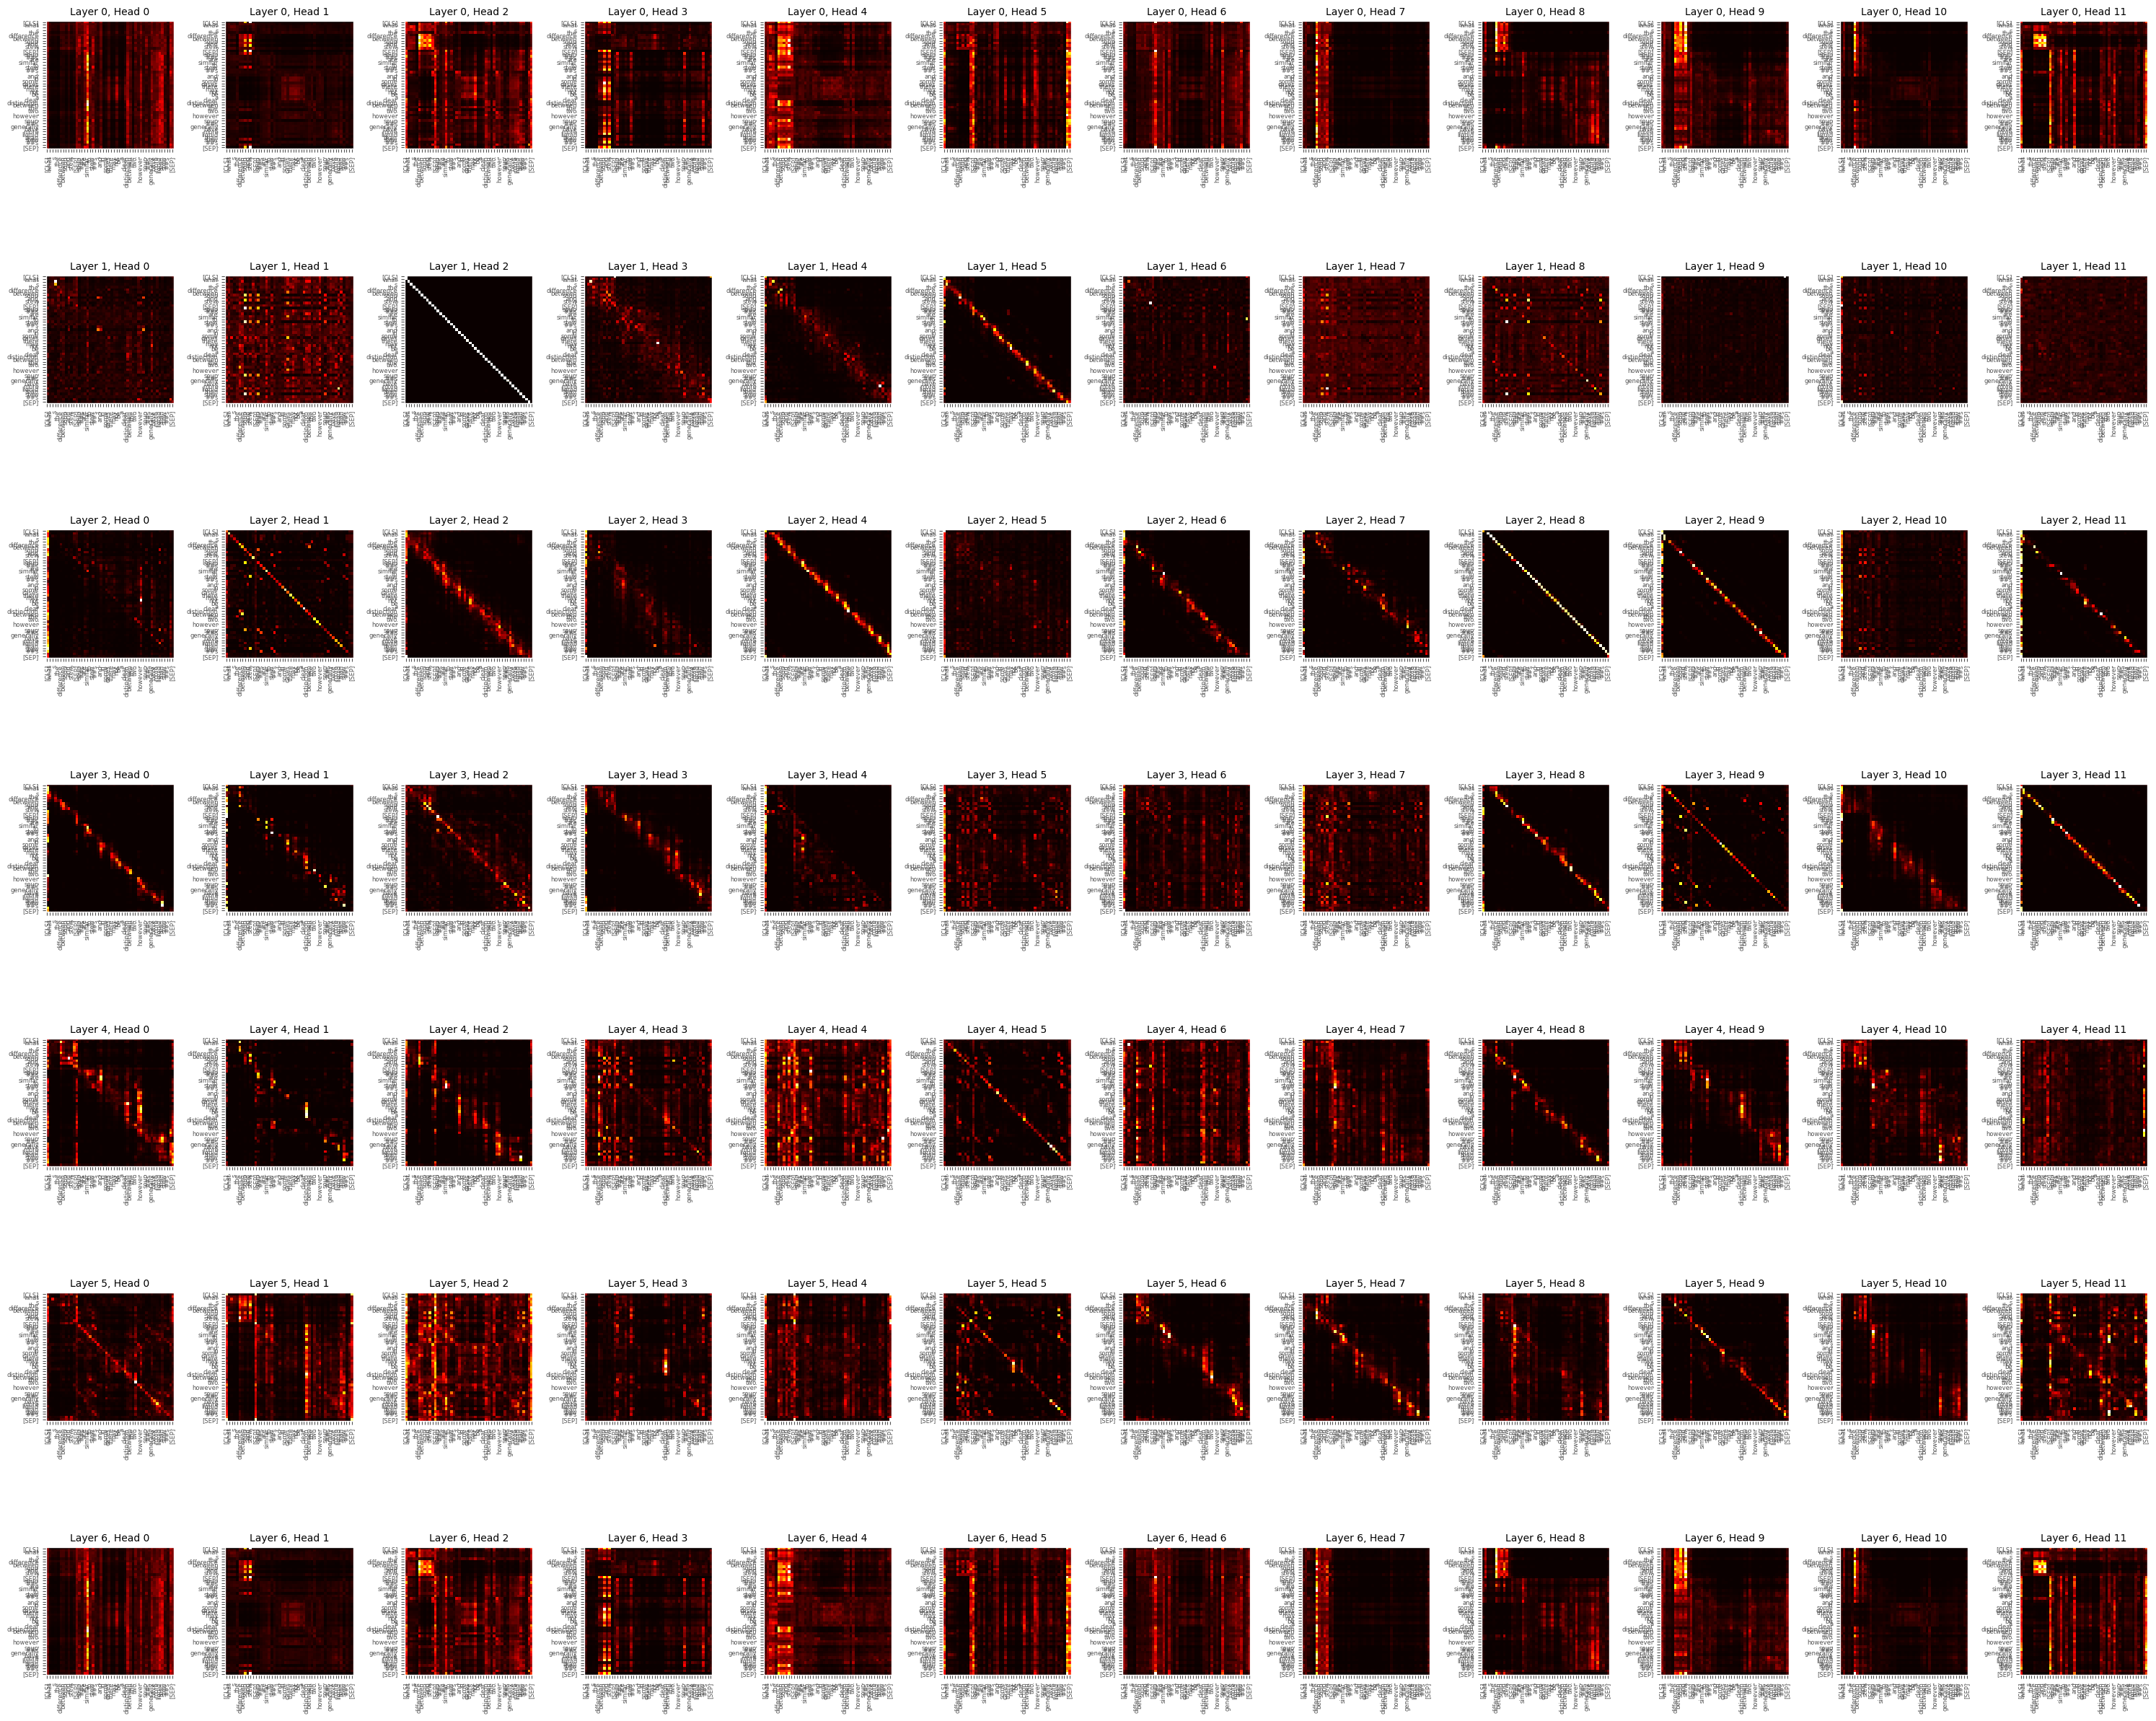

In [27]:
attention_weights = outputs['attentions']

num_heads = attention_weights[0][0].shape[0]
num_layers = last_layer - first_layer

tokens = tokenizer.convert_ids_to_tokens(input_ids[0].flatten().cpu().numpy())

pad_indices = [i for i, token in enumerate(tokens) if token == '[PAD]']
filtered_tokens = [token for token in tokens if token != '[PAD]']

fig, axes = plt.subplots(num_layers, num_heads, figsize=(30, 25))

for i, layer_idx in enumerate(range(first_layer, last_layer)):
    for j, head_idx in enumerate(range(0, num_heads)):
        attention_head_weights = attention_weights[layer_idx-1][0][head_idx].cpu().numpy()

        filtered_attention_weights = np.delete(attention_head_weights, pad_indices, axis=0)
        filtered_attention_weights = np.delete(filtered_attention_weights, pad_indices, axis=1)

        ax = axes[i, j] if num_layers > 1 else axes[j]  # Adjust indexing for single-layer case
        im = ax.imshow(filtered_attention_weights, cmap='hot', interpolation='nearest')
        ax.set_title(f"Layer {layer_idx}, Head {head_idx}", fontsize=10)
        ax.set_xticks(range(len(filtered_tokens)))
        ax.set_xticklabels(filtered_tokens, rotation=90, fontsize=6)
        ax.set_yticks(range(len(filtered_tokens)))
        ax.set_yticklabels(filtered_tokens, fontsize=6)
        ax.grid(False)

# Adjust layout
fig.tight_layout()
plt.show()

Checking more closely one of the layers:

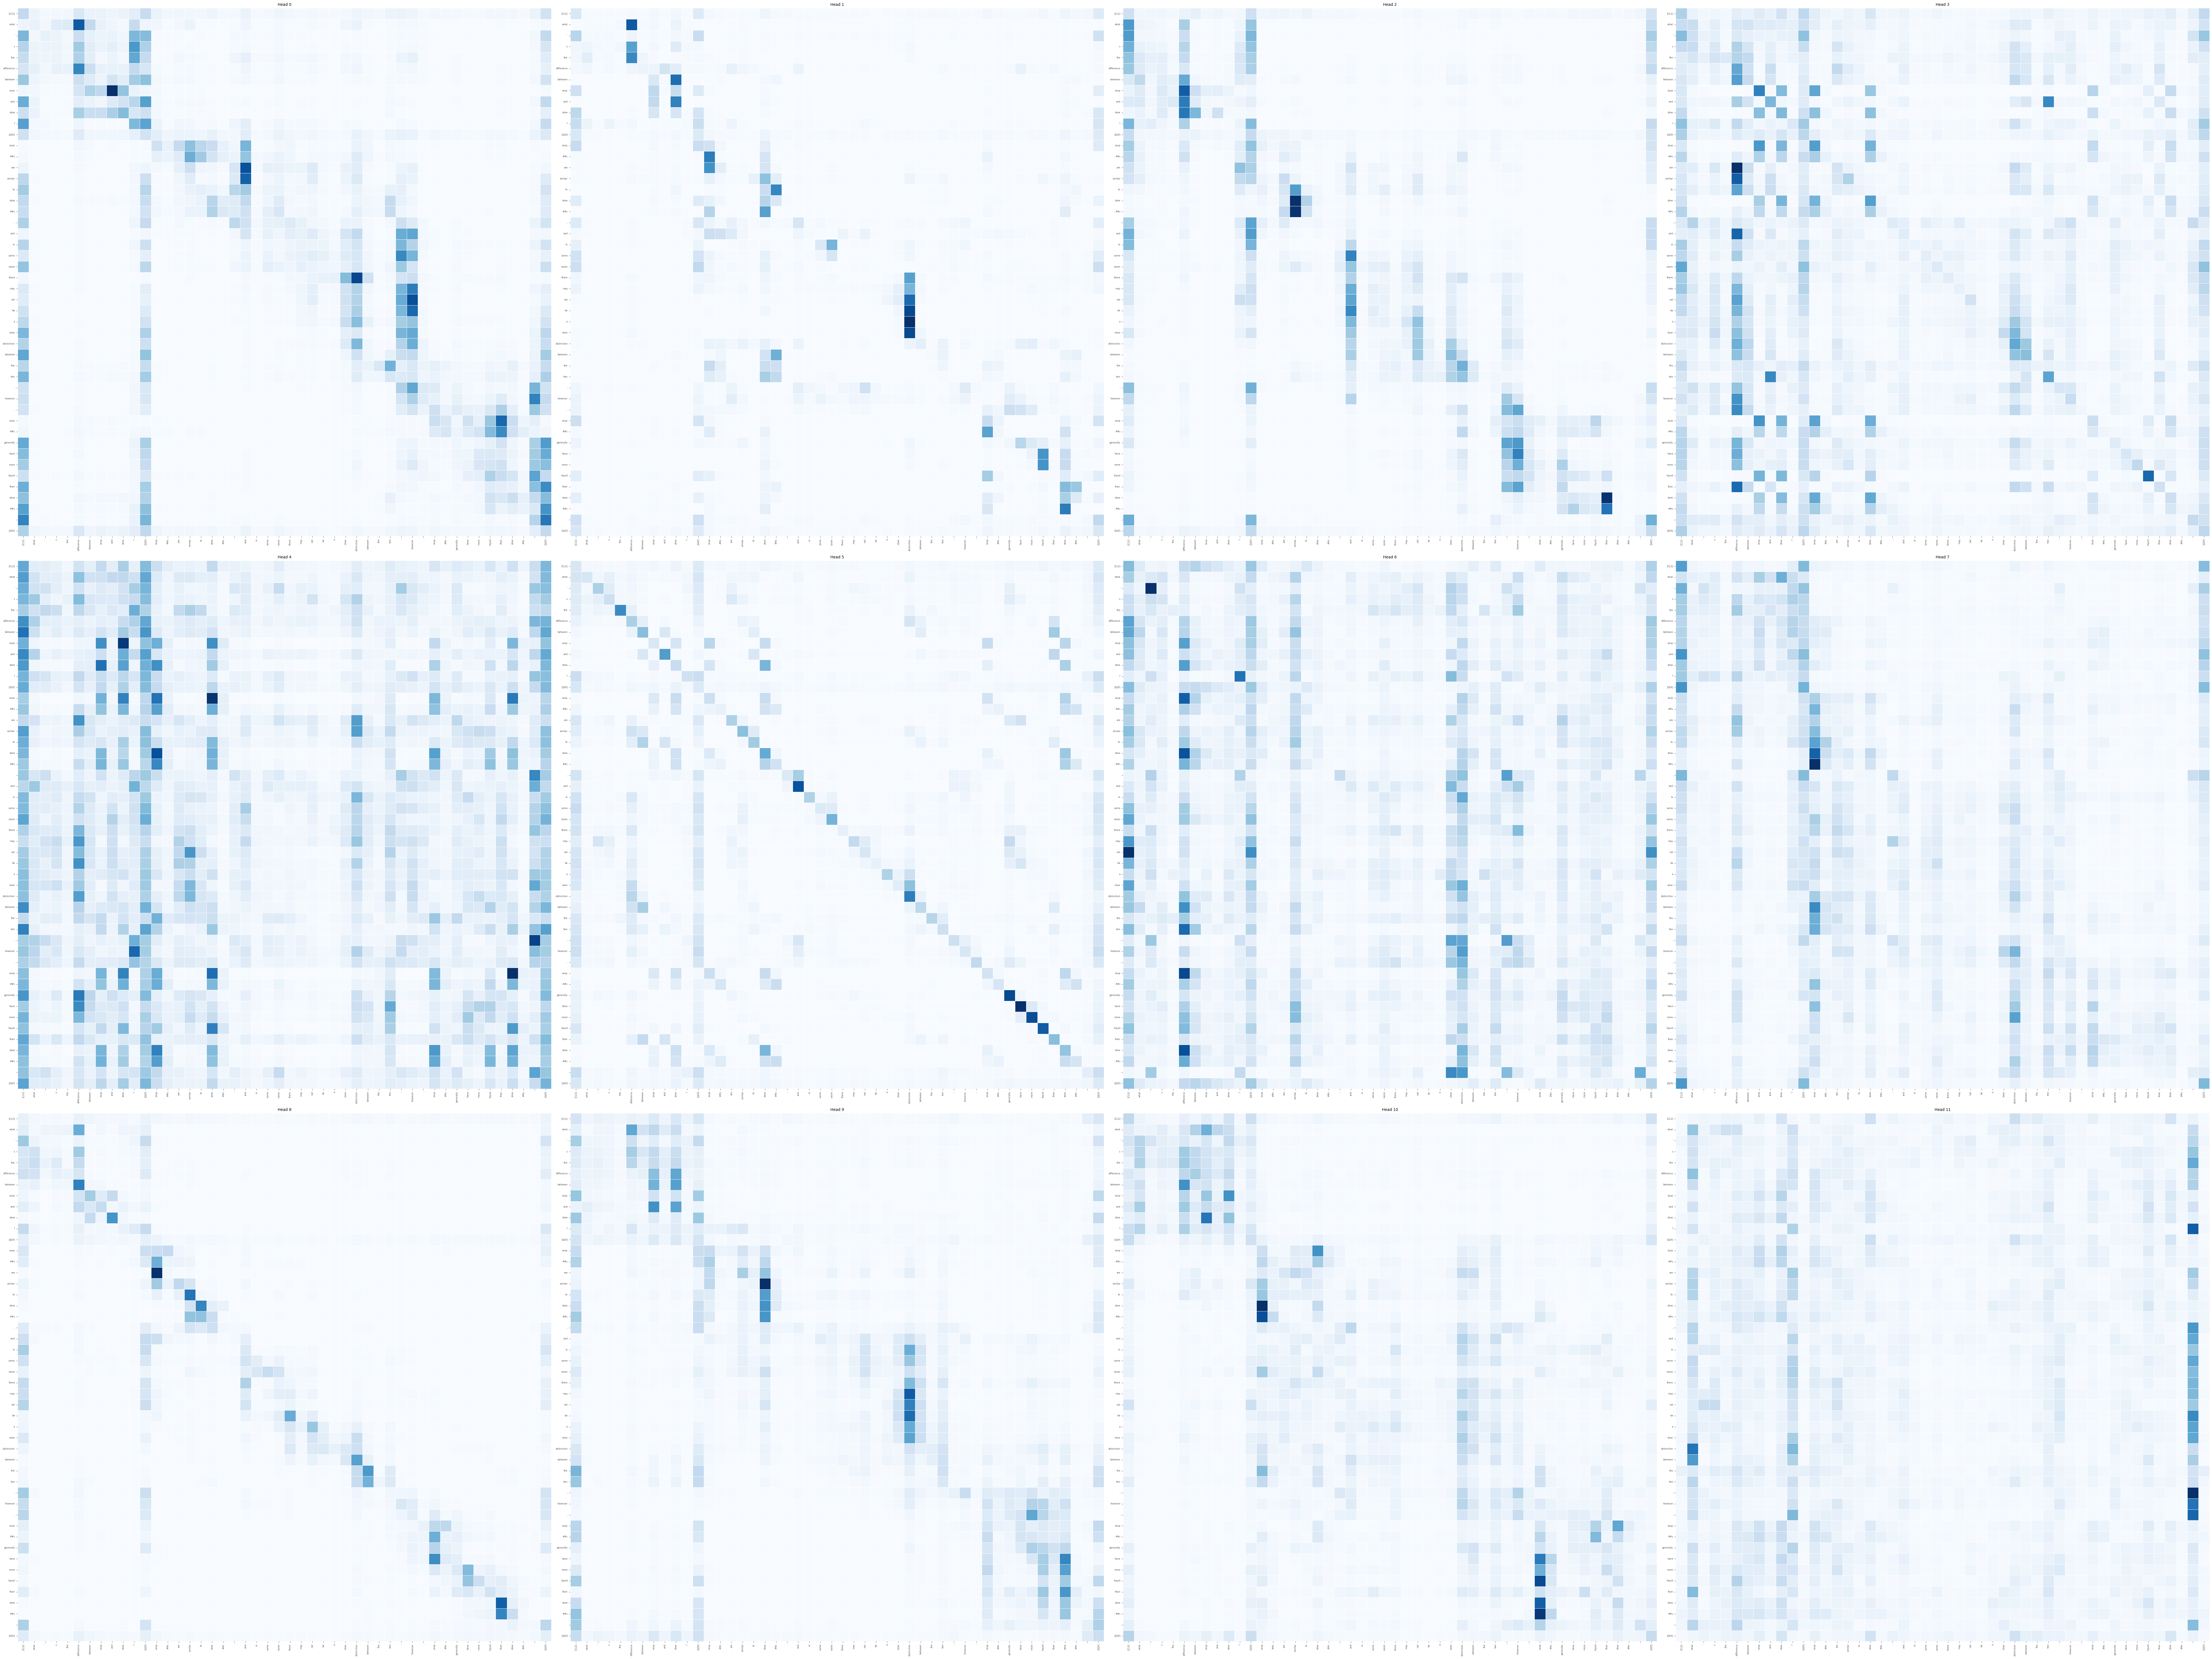

In [28]:
#layer we're visualizing
layer_idx = 3

batch_idx = 0
attention_weights = outputs['attentions'][layer_idx][batch_idx]

tokens = tokenizer.convert_ids_to_tokens(input_ids[0].flatten().cpu().numpy())

pad_indices = [i for i, token in enumerate(tokens) if token == '[PAD]']
filtered_tokens = [token for token in tokens if token != '[PAD]']

num_heads = attention_weights.shape[0]

plots_per_row = 4
num_rows = (num_heads + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20 * plots_per_row, 20*num_rows), squeeze=False)

for head_idx in range(num_heads):
    attention = attention_weights[head_idx].detach().numpy()
    filtered_attention = np.delete(attention, pad_indices, axis=0)
    filtered_attention = np.delete(filtered_attention, pad_indices, axis=1)

    row = head_idx // plots_per_row
    col = head_idx % plots_per_row
    ax = axes[row, col]

    sns.heatmap(filtered_attention,
                xticklabels=filtered_tokens, yticklabels=filtered_tokens,
                cmap='Blues', cbar=False, ax=ax, linewidths=0.5)

    ax.set_title(f"Head {head_idx}", fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

for row in range(num_rows):
    for col in range(plots_per_row):
        if row * plots_per_row + col >= num_heads:
            axes[row, col].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [29]:
test_bed.train_relevance_judgments.loc[:,'topic_turn_id'].unique()

array(['1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '1_9',
       '1_10', '1_11', '1_12', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6',
       '2_7', '2_8', '2_9', '2_10', '2_11', '4_1', '4_2', '4_3', '4_4',
       '4_5', '4_6', '4_7', '4_8', '4_9', '7_1', '7_2', '7_3', '7_4',
       '7_5', '7_6', '7_7', '7_8', '7_9', '7_10', '7_11', '15_1', '15_2',
       '15_3', '15_4', '15_5', '15_6', '15_7', '17_1', '17_2', '17_3',
       '17_4', '17_5', '17_6', '17_7', '17_8', '17_9', '17_10', '18_1',
       '18_2', '18_3', '18_4', '18_5', '18_6', '18_7', '18_8', '18_9',
       '18_10', '18_11', '22_1', '22_2', '22_3', '22_4', '22_5', '22_6',
       '22_7', '22_8', '22_9', '22_10', '23_1', '23_2', '23_3', '23_4',
       '23_5', '23_6', '23_7', '23_8', '24_1', '24_2', '24_3', '24_4',
       '24_5', '24_6', '24_7', '24_8', '25_1', '25_2', '25_3', '25_4',
       '25_5', '25_6', '25_7', '25_8', '25_9', '27_1', '27_2', '27_3',
       '27_4', '27_5', '27_6', '27_7', '30_1', '30_2', '30_3', '30_4'

In [30]:
test_bed.train_relevance_judgments

,topic_turn_id,dummy,docid,rel
0,1_1,0,MARCO_955948,2
1,1_1,0,MARCO_6203672,2
2,1_1,0,MARCO_849267,0
3,1_1,0,MARCO_2331424,0
4,1_1,0,MARCO_4455128,0
...,...,...,...,...
2394,30_7,0,MARCO_4282236,0
2395,30_7,0,MARCO_6551052,0
2396,30_7,0,MARCO_4225659,0
2397,30_7,0,MARCO_6645461,0


In [31]:
df = test_bed.train_relevance_judgments.drop(columns=['dummy'])
df.loc[df['rel'] == 1, 'rel'] = 0 # TODO: check differences if we kept these at 1
df.loc[df['rel'] == 2, 'rel'] = 1
df

,topic_turn_id,docid,rel
0,1_1,MARCO_955948,1
1,1_1,MARCO_6203672,1
2,1_1,MARCO_849267,0
3,1_1,MARCO_2331424,0
4,1_1,MARCO_4455128,0
...,...,...,...
2394,30_7,MARCO_4282236,0
2395,30_7,MARCO_6551052,0
2396,30_7,MARCO_4225659,0
2397,30_7,MARCO_6645461,0


In [32]:
def get_raw_utterance(data, topic_turn):
    topic_num, turn_num = map(int, topic_turn.split('_'))

    for topic in data:
        if topic['number'] == topic_num:
            for turn in topic['turn']:
                if turn['number'] == turn_num:
                    return turn['raw_utterance']
    return None

In [33]:
new_data = []

# an effort of saving computation time on getting repeated topic ids
last_topic = ''
last_utterance = ''

print('documents not found in opensearch:')
for index, row in df.iterrows():

    doc_id = row['docid']
    try:
        doc_body = opensearch.get_doc_body(doc_id) # the file may not exist, hence the try catch
        topic_turn_id = row['topic_turn_id']  # Ex.: '1_1'
        if (last_topic == topic_turn_id):
            raw_utterance = last_utterance
        else:
            raw_utterance = get_raw_utterance(test_bed.train_topics, topic_turn_id)
            last_utterance = raw_utterance
            last_topic = topic_turn_id

        relevance = row['rel']

        # Adicionar os dados à nova estrutura
        new_data.append({
            'raw_utterance': raw_utterance,
            'doc_body': doc_body,
            'relevance': relevance
        })
    except Exception as e:
        print('-',doc_id)

df2 = pd.DataFrame(new_data)

documents not found in opensearch:


- WAPO_dca3e1d51591ec1450892efeb2628fbb-29


- WAPO_8c60626e073a9014cd8d5777f069ce4c-55


- WAPO_f7853b573697635e8fc2376376833316-64


- WAPO_7cd76e3d78db53070edbdfae5d6fd5bb-4


- CAR_2ad9993f5438dbe27829896b61b4f35ec0249190


- CAR_21768967e0643d5de148164bae4b9cca57a80c30


- WAPO_7cd76e3d78db53070edbdfae5d6fd5bb-4


- WAPO_34065be04d187dbc8b30b305a160663e-12


- CAR_27f2ee6f55dadbc1318420d1b602cf75a7ffdaae


- CAR_27f2ee6f55dadbc1318420d1b602cf75a7ffdaae


- CAR_27f2ee6f55dadbc1318420d1b602cf75a7ffdaae


- CAR_27f2ee6f55dadbc1318420d1b602cf75a7ffdaae


- WAPO_22be1208d2a1acae2fa7358735abbc39-14


- WAPO_4391f3551b824cad91e7ce2d5ac6b10a-5


- CAR_1f25334ad14f0d1d02e985f815f3538593315994


- WAPO_6ab8fcd10a241cc72f2ded2ac8c8c1bb-7


- WAPO_22e14dee-a318-11e4-9f89-561284a573f8-3


- WAPO_22e14dee-a318-11e4-9f89-561284a573f8-5


- WAPO_6ab8fcd10a241cc72f2ded2ac8c8c1bb-7


- CAR_c22da7f9162648ce1f7263e202d418f4a2f12ff7


- WAPO_8a64390e-d377-11e6-9cb0-54ab630851e8-14


- WAPO_35571ff2c4f4afa66aebf06146e91b77-12


- WAPO_7103040f46ea9e8e50fda26065ee871d-2


- WAPO_3e95d46389675a2d91842f322f8b7b41-14


- WAPO_fd6db255e6d04443b6a750e060e2727c-25


- WAPO_79dbedb4-e24c-11e6-a453-19ec4b3d09ba-1


- CAR_7fa69973a53346d3ac1d67cccab56bb8ad159d50


- CAR_1b40cae08012b8add2379f75f444d38c228dd86e


- WAPO_80cb70d6-6a2e-11e1-acc6-32fefc7ccd67-13


- WAPO_b0bdc619385a1c8dab99fd72d5173a4f-4


- WAPO_d0936b1c-7880-11e7-9eac-d56bd5568db8-4


- WAPO_122c0954-efbd-11e2-9008-61e94a7ea20d-7


- WAPO_51b05e710d56c5b388cd161a3cf3c1e3-8


- WAPO_31bce704-8d18-11e3-98ab-fe5228217bd1-10


- WAPO_1d63508cd600f12015fb888597b7c378-4


- WAPO_00e708ec-6a21-11e1-acc6-32fefc7ccd67-8


- WAPO_51b05e710d56c5b388cd161a3cf3c1e3-9


- WAPO_75cfab63a253f8e76390d027bd0de5a0-5


- WAPO_ad95f99e5aa8915f254e055a659a4956-24


- WAPO_0a95c1aa-1d9b-11e4-ab7b-696c295ddfd1-14


- WAPO_da42ac0c-f141-11e6-9fb1-2d8f3fc9c0ed-2


- MARCO_4286598


- WAPO_5f9b07d5f3fed266ad8b22edb5163ba4-1


- WAPO_5f9b07d5f3fed266ad8b22edb5163ba4-1


- WAPO_5f9b07d5f3fed266ad8b22edb5163ba4-1


- WAPO_5f9b07d5f3fed266ad8b22edb5163ba4-1


- WAPO_5f9b07d5f3fed266ad8b22edb5163ba4-1


In [34]:
df2

,raw_utterance,doc_body,relevance
0,What is a physician's assistant?,Physician assistants work under the supervisio...,1
1,What is a physician's assistant?,Physician assistants work in all areas of medi...,1
2,What is a physician's assistant?,Salary for Physician Assistants. Also known as...,0
3,What is a physician's assistant?,"$54,000. Average Physician Assistant Physician...",0
4,What is a physician's assistant?,1 The typical physician assistant is female. 2...,0
...,...,...,...
2347,Tell me about how I can share files.,File sharing with password protection from win...,0
2348,Tell me about how I can share files.,How can I find and delete all video files from...,0
2349,Tell me about how I can share files.,Windows Explorer is the file management applic...,0
2350,Tell me about how I can share files.,"Yes, in most cases you should be able to open ...",0


In [35]:
import torch.nn as nn

def extract_cls(df2, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    query_pairs = [
      f"{row['raw_utterance']} [SEP] {row['doc_body']}"
      for _, row in df2.iterrows()
    ]

    embedding_dim = 384

    embeddings = np.zeros((len(query_pairs), embedding_dim))

    # Iterate over all documents, in batches of size <batch_size>
    for batch_idx in range(0, len(df2), batch_size):

        # Get the current batch of samples
        batch_data = query_pairs[batch_idx:batch_idx + batch_size]

        inputs = tokenizer.batch_encode_plus(batch_data,
                                       return_tensors='pt',  # pytorch tensors
                                       add_special_tokens=True,  # Add CLS and SEP tokens
                                       max_length = 512, # Max sequence length
                                       truncation = True, # Truncate if sequences exceed the Max Sequence length
                                       padding = True) # Add padding to forward sequences with different lengths

        # Forward the batch of (query, doc) sequences
        with torch.no_grad():
            inputs = {key: value.to(device) for key, value in inputs.items()}
            outputs = model(**inputs)

        # Get the CLS embeddings for each pair query, document
        if 'hidden_states' in outputs.keys():
            batch_cls = outputs['hidden_states'][-1][:, 0, :]

        # L2-Normalize CLS embeddings. Embeddings norm will be 1.
        batch_cls = torch.nn.functional.normalize(batch_cls, p=2, dim=1)

        # Store the extracted CLS embeddings from the batch on the memory-mapped ndarray
        embeddings[batch_idx:batch_idx + batch_size] = batch_cls.detach().cpu().numpy()

    return embeddings

In [36]:
# Extrair embeddings
train_embeddings = extract_cls(df2, batch_size=32)


In [37]:
train_embeddings

array([[ 0.00043872,  0.00705111,  0.00157016, ..., -0.00594859,
        -0.00484167,  0.00868492],
       [ 0.00233353,  0.00703278,  0.00096687, ..., -0.00408841,
        -0.00226529,  0.00879406],
       [ 0.0022323 ,  0.00324872, -0.00179494, ...,  0.00139483,
         0.00080838,  0.01349317],
       ...,
       [ 0.00231463,  0.00754936, -0.00056617, ...,  0.00337783,
        -0.00721215,  0.02282442],
       [-0.01255516,  0.01041625, -0.00041246, ...,  0.00049654,
        -0.01230543,  0.0274538 ],
       [-0.0080453 ,  0.0165558 , -0.0024876 , ...,  0.00680741,
        -0.00633149,  0.01808756]])

In [38]:
train_embeddings.shape

(2352, 384)

In [39]:
# Similaridade entre o primeiro e o segundo embedding
sim = cosine_similarity(train_embeddings[0].reshape(1, -1), train_embeddings[1].reshape(1, -1))
print(f"Similarity: {sim}")

Similarity: [[0.9995791]]


In [40]:

# np.random.seed(42)  # Reproducibilidade
# embedding_dim = 384
# num_pairs = 10  # Número de pares para este exemplo
# embeddings = np.random.rand(num_pairs, embedding_dim)

# relevances = np.random.choice([0, 1], size=num_pairs)  # 0 ou 1

# data = []

# # Calculando similaridade entre pares consecutivos
# for i in range(len(embeddings) - 1):
#     sim = cosine_similarity(embeddings[i].reshape(1, -1), embeddings[i + 1].reshape(1, -1))[0][0]
#     data.append({
#         "pair": f"Pair {i}-{i + 1}",
#         "similarity": sim,
#         "relevance": relevances[i]
#     })

# df_similarity = pd.DataFrame(data)


In [41]:
# print(df_similarity)

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_embeddings, df2['relevance'],
                                                          test_size = 0.20, random_state = 12)

In [43]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, class_weight='balanced').fit(x_train, y_train)

The model parameters are given by the coef_ variable:

In [44]:
print(clf.coef_)

[[ 2.07786549e-01 -4.69186200e-02  1.22133130e-01 -1.00198347e-01
  -4.73960369e-01  2.92213974e-01  2.99904803e-01 -1.21690908e-01
   1.04528309e-01 -1.78509317e-01 -6.94590781e-02  3.25027167e-02
   3.20962525e-01  2.23798826e-04 -4.00342751e-01  1.36988861e-01
   1.89455226e-01 -1.75551965e-02 -1.37739593e-01 -8.15356988e-02
  -4.31698963e-01 -1.49297170e-01 -6.29564160e-03 -3.10929231e-02
  -2.82478992e-02 -1.76279660e-01  1.07611031e-01  4.32144246e-02
   2.65085306e-01 -4.10009948e-01  2.91300496e-01 -1.02260251e-01
   8.54244426e-03 -2.48381451e-01  1.59462707e-01  5.84459109e-02
  -1.33340543e-01  9.65290404e-02  1.01444960e-01 -1.05927927e-01
   5.09327800e-02  1.22455499e-01  1.14275419e-01  3.51297890e-02
  -2.34267990e-01  6.02581848e-01  1.85846703e-01 -3.19004335e-01
  -3.54496038e-01  9.58670159e-03  2.04111995e-02  5.52265586e-02
   4.02605446e-01 -1.60828236e-01 -1.07112568e-01  1.69865574e-01
  -1.08100123e-01 -1.24355356e-01  4.42486503e-01  9.76297841e-03
   4.13421

In [45]:
from sklearn.metrics import classification_report
predict_train = clf.predict(x_train)
predicted_test = clf.predict(x_test)

In [46]:
target_names = ['neg', 'pos']
print(classification_report(predict_train, y_train, target_names=target_names))

              precision    recall  f1-score   support

         neg       0.63      0.92      0.75      1118
         pos       0.67      0.22      0.33       763

    accuracy                           0.64      1881
   macro avg       0.65      0.57      0.54      1881
weighted avg       0.65      0.64      0.58      1881



In [47]:
print(classification_report(predicted_test, y_test, target_names=target_names))

              precision    recall  f1-score   support

         neg       0.65      0.94      0.77       285
         pos       0.73      0.23      0.35       186

    accuracy                           0.66       471
   macro avg       0.69      0.59      0.56       471
weighted avg       0.68      0.66      0.61       471



We don't see much fluctuation between training and testing data results, so model should be stable enough

## Model inference

In [48]:
def get_top_passages(query, k=1000):
  opensearch_results = opensearch.search_body(query, numDocs = k)

  best_passages = []
  for index, row in opensearch_results.iterrows():
            doc_id = row['_id']
            doc_body = opensearch.get_doc_body(doc_id)
            best_passages.append(doc_body)
  return best_passages

In [49]:
def extract_embeddings_for_inference(query, passages, tokenizer, model, batch_size=8):

  return extract_cls(df2=query, batch_size=batch_size)

In [50]:
def rank_passages_with_classifier(embeddings, passages, clf):
  assert embeddings.shape[1] == clf.coef_.shape[1], \
    f"Embedding size mismatch. Got {embeddings.shape[1]}, expected {clf.coef_.shape[1]}"
  scores = clf.predict_proba(embeddings)[:, 1]
  ranked_passages = sorted(
      zip(passages, scores),
      key=lambda x: x[1],
      reverse=True
  )
  return ranked_passages

In [51]:
def rank_and_display_passages(query, tokenizer, model, clf, k=1000):
  top_passages = get_top_passages(query, k)
  embeddings = extract_embeddings_for_inference(query, top_passages, tokenizer, model)
  ranked_passages = rank_passages_with_classifier(embeddings, top_passages, clf)

  print(f"Query: {query}")
  for idx, (passage, score) in enumerate(ranked_passages):
    print(f"Rank: {idx+1}, Score: {score:.4f}, Passage: {passage}")

  return ranked_passages

In [52]:
test_query2 = get_raw_utterance(test_bed.test_topics, '31_1')
test_query3 = get_raw_utterance(test_bed.test_topics, '32_1')

this part takes quite a bit...

In [53]:
ranked_passages = rank_and_display_passages(test_query2, tokenizer, model, clf, k=1000)

KeyboardInterrupt: 

In [ ]:
ranked_passages = rank_and_display_passages(test_query3, tokenizer, model, clf, k=1000)

# Query rewriting

1) Query re-writing method: using a generative model, re-write the current utterance using the past utterances

In [54]:
import requests
conv_id = "31"
def generate_text_with_ollama(prompt):
    """
    Sends a prompt to an Ollama server and retrieves the generated text.

    Args:
        prompt (str): The text prompt to send to the model.

    Returns:
        str: Generated text from the model.
    """
    endpoint = "https://twiz.novasearch.org/ollama"
    data = {
        "model": 'llama3.2',
        "stream": False,
        "prompt": prompt
    }
    print(data)

    try:
        response = requests.post(endpoint, json=data)
        response.raise_for_status()
        return response.json()["response"]
    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None

In [55]:
PROMPT = 'Rewrite the questions :'
for i in range(9):
    PROMPT+= " \"" + str(get_raw_utterance(test_bed.test_topics, f'31_{i+1}')) + "\" "

response_text = generate_text_with_ollama(PROMPT)

if response_text:
    print()
    print("Generated Text:")
    print(response_text)
else:
    print("Failed to retrieve a response.")

{'model': 'llama3.2', 'stream': False, 'prompt': 'Rewrite the questions : "What is throat cancer?"  "Is it treatable?"  "Tell me about lung cancer."  "What are its symptoms? "  "Can it spread to the throat?"  "What causes throat cancer?"  "What is the first sign of it?"  "Is it the same as esophageal cancer?"  "What\'s the difference in their symptoms?" '}

Generated Text:
Here are rewritten versions of the questions:

1. What is throat cancer, and how does it affect the body?

2. Can throat cancer be effectively treated, and what are the chances of recovery?

3. What is lung cancer, and what can patients expect from a diagnosis?

4. What common symptoms signal that a person may have lung cancer?

5. Can lung cancer spread to the surrounding areas or other parts of the body?

6. What are some known risk factors for developing throat cancer?

7. What is often the first noticeable sign or symptom of throat cancer, and how should it be addressed?

8. Is esophageal cancer similar to throat

In [56]:
import re

original_queries = []
for i in range(9):
    original_queries.append(str(get_raw_utterance(test_bed.test_topics, f'31_{i+1}')))
print(original_queries)

rewritten_queries = re.findall(r'^\d+\.\s(.+)', response_text, re.MULTILINE)
print(rewritten_queries)


['What is throat cancer?', 'Is it treatable?', 'Tell me about lung cancer.', 'What are its symptoms? ', 'Can it spread to the throat?', 'What causes throat cancer?', 'What is the first sign of it?', 'Is it the same as esophageal cancer?', "What's the difference in their symptoms?"]
['What is throat cancer, and how does it affect the body?', 'Can throat cancer be effectively treated, and what are the chances of recovery?', 'What is lung cancer, and what can patients expect from a diagnosis?', 'What common symptoms signal that a person may have lung cancer?', 'Can lung cancer spread to the surrounding areas or other parts of the body?', 'What are some known risk factors for developing throat cancer?', 'What is often the first noticeable sign or symptom of throat cancer, and how should it be addressed?', 'Is esophageal cancer similar to throat cancer, and what sets them apart in terms of symptoms and diagnosis?', 'What distinct symptoms can patients with lung cancer expect compared to tho

2) Evaluate the query re-writing with LMD and BERT methods.

Original: What is throat cancer?
Rewritten: What is throat cancer, and how does it affect the body?
Cosine Similarity: 0.8191
--------------------------------------------------
Original: Is it treatable?
Rewritten: Can throat cancer be effectively treated, and what are the chances of recovery?
Cosine Similarity: 0.0000
--------------------------------------------------
Original: Tell me about lung cancer.
Rewritten: What is lung cancer, and what can patients expect from a diagnosis?
Cosine Similarity: 0.3304
--------------------------------------------------
Original: What are its symptoms? 
Rewritten: What common symptoms signal that a person may have lung cancer?
Cosine Similarity: 0.3822
--------------------------------------------------
Original: Can it spread to the throat?
Rewritten: Can lung cancer spread to the surrounding areas or other parts of the body?
Cosine Similarity: 0.6886
--------------------------------------------------
Original: What causes throat cancer?
Rewritten

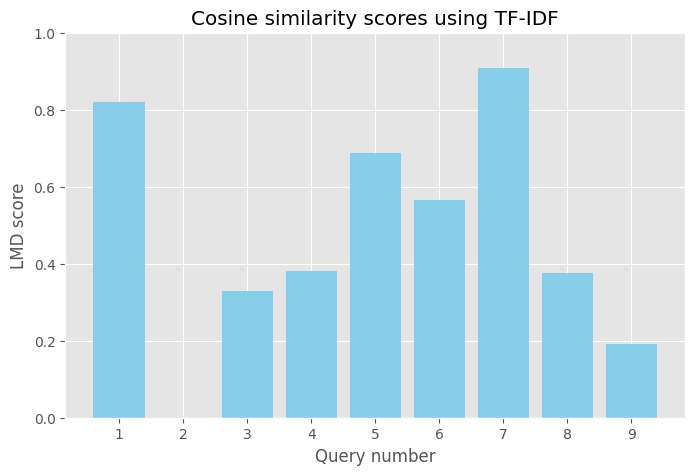

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
original_tfidf = vectorizer.fit_transform(original_queries).toarray()
rewritten_tfidf = vectorizer.transform(rewritten_queries).toarray()


cosine_similarities = [
    cosine_similarity(original.reshape(1, -1), rewritten.reshape(1, -1))[0][0]
    for original, rewritten in zip(original_tfidf, rewritten_tfidf)
]


for i, score in enumerate(cosine_similarities):
    print(f"Original: {original_queries[i]}")
    print(f"Rewritten: {rewritten_queries[i]}")
    print(f"Cosine Similarity: {score:.4f}" if score is not None else "Cosine Similarity: Undefined (empty vectors)")
    print("-" * 50)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cosine_similarities) + 1), cosine_similarities, color='skyblue')
plt.title("Cosine similarity scores using TF-IDF")
plt.xlabel("Query number")
plt.ylabel("LMD score")
plt.xticks(range(1, len(cosine_similarities) + 1))
plt.ylim(0, 1)
plt.show()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Original: What is throat cancer?
Rewritten: What is throat cancer, and how does it affect the body?
Cosine Similarity (BERT): 0.9667
--------------------------------------------------
Original: Is it treatable?
Rewritten: Can throat cancer be effectively treated, and what are the chances of recovery?
Cosine Similarity (BERT): 0.8764
--------------------------------------------------
Original: Tell me about lung cancer.
Rewritten: What is lung cancer, and what can patients expect from a diagnosis?
Cosine Similarity (BERT): 0.8536
--------------------------------------------------
Original: What are its symptoms? 
Rewritten: What common symptoms signal that a person may have lung cancer?
Cosine Similarity (BERT): 0.9132
--------------------------------------------------
Original: Can it spread to the throat?
Rewritten: Can lung cancer spread to the surrounding areas or other parts of the body?
Cosine Similarity (BERT): 0.8949
--------------------------------------------------
Original: W

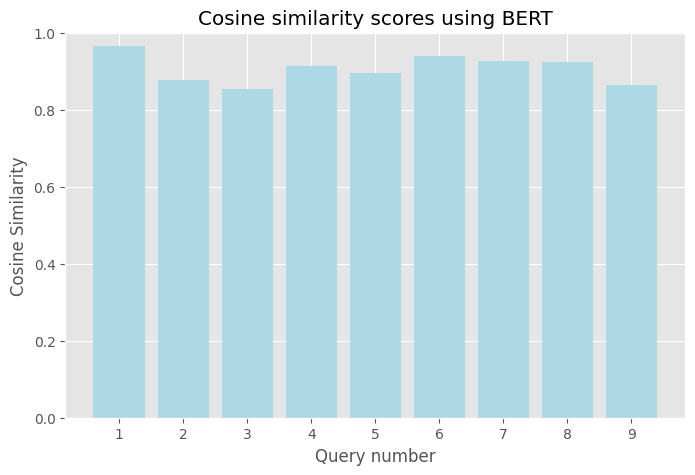

In [58]:
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import torch


model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states=True)


def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

original_embeddings = [get_bert_embedding(query) for query in original_queries]
rewritten_embeddings = [get_bert_embedding(query) for query in rewritten_queries]

cosine_similarities = [
    cosine_similarity(original.reshape(1, -1), rewritten.reshape(1, -1))[0][0]
    for original, rewritten in zip(original_embeddings, rewritten_embeddings)
]

for i, score in enumerate(cosine_similarities):
    print(f"Original: {original_queries[i]}")
    print(f"Rewritten: {rewritten_queries[i]}")
    print(f"Cosine Similarity (BERT): {score:.4f}")
    print("-" * 50)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cosine_similarities) + 1), cosine_similarities, color='lightblue')
plt.title("Cosine similarity scores using BERT")
plt.xlabel("Query number")
plt.ylabel("Cosine Similarity")
plt.xticks(range(1, len(cosine_similarities) + 1))
plt.ylim(0, 1)
plt.show()


3) Use the evaluation framework of the first milestone to assess the success of the implemented methods

In [59]:

conversation = {}
topics = {}

for i,query in enumerate(rewritten_queries):
    turn_id = i + 1
    utterance = query
    topic_turn_id = f'{conv_id}_{turn_id}'
    topics[topic_turn_id] = utterance
    conversation[f'{conv_id}_{turn_id}'] = {
        "conv_id": int(conv_id),
        "turn_id": turn_id,
        "utterance": utterance
    }


opensearch = osearch.OSsimpleAPI()
print(conversation)

{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'kwiz': {'settings': {'index': {'creation_date': '1728153198145',
                                 'knn': 'true',
                                 'number_of_replicas': '0',
                                 'number_of_shards': '1',
                                 'provided_name': 'kwiz',
                                 'refresh_interval': '-1',
                                 'similarity': {'default': {'lambda': '0.7',
                                                            'type': 'LMJelinekMercer'}},
                                 'uuid': 'qkpQ7pcwS7iT1IOTsfwRNg',
                                 'version': {'created': '135238227'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'kwiz': {'mappings': {'properties': {'collection': {'type': 'keyword'},
                   

In [60]:
def rerank_with_bert(query, ranked_passages, tokenizer, clf):
    embeddings = extract_embeddings_for_inference(query, ranked_passages, tokenizer, bert_model)
    return rank_passages_with_classifier(embeddings, ranked_passages, clf)

In [61]:
query = rewritten_queries[4] #change number for different query

print(f"Processing query: {query}")
initial_ranked_passages = get_top_passages(query, k=1000)

Processing query: Can lung cancer spread to the surrounding areas or other parts of the body?


In [62]:
queryDF = pd.DataFrame({
    "raw_utterance": [query] * len(initial_ranked_passages),
    "doc_body": initial_ranked_passages
})

In [63]:
queryDF

,raw_utterance,doc_body
0,Can lung cancer spread to the surrounding area...,A cancer that has spread to another part of th...
1,Can lung cancer spread to the surrounding area...,Lung cancer can start anywhere in the lungs an...
2,Can lung cancer spread to the surrounding area...,Lung cancer is a malignant tumour that starts ...
3,Can lung cancer spread to the surrounding area...,Stage 4 Non-Small Cell Lung Cancer. Stage IV n...
4,Can lung cancer spread to the surrounding area...,"Lung cancer, also known as lung carcinoma, is ..."
...,...,...
995,Can lung cancer spread to the surrounding area...,Turkey is the first country to recognise Kazak...
996,Can lung cancer spread to the surrounding area...,The end goal is to use such artificial molecul...
997,Can lung cancer spread to the surrounding area...,Causes of throat cancer. The exact cause of th...
998,Can lung cancer spread to the surrounding area...,"Modern academic fencing, the Mensur, is neithe..."


In [64]:
reranked_passages = rerank_with_bert(queryDF, initial_ranked_passages, tokenizer, clf)

print(f"Reranked Passages for query '{query}':")
for idx, (passage, score) in enumerate(reranked_passages):
    print(f"Rank: {idx+1}, Score: {score:.4f}, Passage: {passage[:100]}...")
    # if idx >= 4:
    #     break

Reranked Passages for query 'Can lung cancer spread to the surrounding areas or other parts of the body?':
Rank: 1, Score: 0.7175, Passage: A cancer that has spread to another part of the body is called a secondary cancer. The most common a...
Rank: 2, Score: 0.6861, Passage: Cancers that spread to the lungs: Cancers that start in other organs (such as the breast, pancreas, ...
Rank: 3, Score: 0.6855, Passage: Cancer is a disease in which cells in the body grow out of control. When cancer starts in the lungs,...
Rank: 4, Score: 0.6682, Passage: Smoking, including secondhand smoke, is the leading cause of lung cancer. Other cancers. Not only do...
Rank: 5, Score: 0.6668, Passage: Cancer is a disease in which cells in the body grow out of control. When cancer starts in the lungs,...
Rank: 6, Score: 0.6655, Passage: Spread to the Brain. Lung cancer is the most common cancer that spreads to the brain, and at least 4...
Rank: 7, Score: 0.6549, Passage: Types and Staging of Lung Cancer. Ther

In [65]:
# reranked_turns = []
# reranked_ap_values = []
# reranked_ndcg_values = []
# reranked_precision_values = []
# reranked_recall_values = []

# print("Reranked with BERT")

# for idx, (passage, score) in enumerate(reranked_passages):
#     try:
#         turn = f"{chosen_topic}_{idx+1}"
#         result_df = pd.DataFrame({"_id": [passage]})

#         p10, recall, ap, ndcg5 = test_bed.eval(result_df, turn)
#         reranked_turns.append(turn)
#         reranked_ap_values.append(ap)
#         reranked_ndcg_values.append(ndcg5)
#         reranked_precision_values.append(p10)
#         reranked_recall_values.append(recall)

#         print(f"Turn: {turn}")
#         print(f"P@10: {p10}, Recall: {recall}, AP: {ap}, NDCG@5: {ndcg5}\n")

#     except Exception as e:
#         print(f"Error on turn {turn}: {e}")
#         break

# print(reranked_turns, reranked_ap_values, reranked_ndcg_values, reranked_precision_values, reranked_recall_values)

# # Plot the comparison
# plt.figure(figsize=(10, 6))
# plt.scatter(turns_LMD, LMD_ap_values, marker='o', label='LMD', alpha=0.7)
# plt.scatter(turns_LMD, BM_ap_values, marker='x', label='BM25', alpha=0.7)
# plt.scatter(reranked_turns, reranked_ap_values, marker='s', label='Reranked with BERT', alpha=0.7)
# plt.title("Evolution of AP for each turn")
# plt.xlabel("Turns")
# plt.ylabel("Scores")
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.savefig("AP_comparison.png")
# plt.close()

# plt.figure(figsize=(10, 6))
# plt.scatter(turns_LMD, LMD_ndcg_values, marker='o', label='LMD', alpha=0.7)
# plt.scatter(turns_LMD, BM_ndcg_values, marker='x', label='BM25', alpha=0.7)
# plt.scatter(reranked_turns, reranked_ndcg_values, marker='s', label='Reranked with BERT', alpha=0.7)
# plt.title("Evolution of NDCG@5 for each turn")
# plt.xlabel("Turns")
# plt.ylabel("Scores")
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.savefig("NDCG5_comparison.png")
# plt.close()

Reranked with BERT
Error on turn 77_1: Relevance score length < k
[] [] [] [] []


In [66]:
PROMPT = 'Summarize these answers into one :'

for i in range(3):
    PROMPT+= " \"" + str(reranked_passages[i][0]) + "\" "

response_text = generate_text_with_ollama(PROMPT)

if response_text:
    print()
    print("Generated Text:")
    print(response_text)
else:
    print("Failed to retrieve a response.")


{'model': 'llama3.2', 'stream': False, 'prompt': 'Summarize these answers into one : "A cancer that has spread to another part of the body is called a secondary cancer. The most common areas that lung cancer spreads to are the lymph nodes (in the chest, abdomen, neck or armpit), the liver, the bones and the brain. More rarely lung cancer can spread to the adrenal glands or to other areas of the body. cancer that has spread to another part of the body is called a secondary cancer. The most common areas that lung cancer spreads to are the lymph nodes (in the chest, abdomen, neck or armpit), the liver, the bones and the brain. More rarely lung cancer can spread to the adrenal glands or to other areas of the body."  "Cancers that spread to the lungs: Cancers that start in other organs (such as the breast, pancreas, kidney, or skin) can sometimes spread (metastasize) to the lungs, but these are not lung cancers. For example, cancer that starts in the breast and spreads to the lungs is still

In [67]:
PROMPT = 'Summarize these passages into one, 50 words or less :'

for i in range(3):
    PROMPT+= " \"" + str(reranked_passages[i][0]) + "\" "

response_text = generate_text_with_ollama(PROMPT)

if response_text:
    print()
    print("Generated Text:")
    print(response_text)
else:
    print("Failed to retrieve a response.")


{'model': 'llama3.2', 'stream': False, 'prompt': 'Summarize these passages into one, 50 words or less : "A cancer that has spread to another part of the body is called a secondary cancer. The most common areas that lung cancer spreads to are the lymph nodes (in the chest, abdomen, neck or armpit), the liver, the bones and the brain. More rarely lung cancer can spread to the adrenal glands or to other areas of the body. cancer that has spread to another part of the body is called a secondary cancer. The most common areas that lung cancer spreads to are the lymph nodes (in the chest, abdomen, neck or armpit), the liver, the bones and the brain. More rarely lung cancer can spread to the adrenal glands or to other areas of the body."  "Cancers that spread to the lungs: Cancers that start in other organs (such as the breast, pancreas, kidney, or skin) can sometimes spread (metastasize) to the lungs, but these are not lung cancers. For example, cancer that starts in the breast and spreads to

In [68]:
PROMPT = 'Provide a detailed explanation based on these passages :'

for i in range(3):
    PROMPT += " \"" + str(reranked_passages[i][0]) + "\" "

response_text = generate_text_with_ollama(PROMPT)

if response_text:
    print()
    print("Generated Text:")
    print(response_text)
else:
    print("Failed to retrieve a response.")

{'model': 'llama3.2', 'stream': False, 'prompt': 'Provide a detailed explanation based on these passages : "A cancer that has spread to another part of the body is called a secondary cancer. The most common areas that lung cancer spreads to are the lymph nodes (in the chest, abdomen, neck or armpit), the liver, the bones and the brain. More rarely lung cancer can spread to the adrenal glands or to other areas of the body. cancer that has spread to another part of the body is called a secondary cancer. The most common areas that lung cancer spreads to are the lymph nodes (in the chest, abdomen, neck or armpit), the liver, the bones and the brain. More rarely lung cancer can spread to the adrenal glands or to other areas of the body."  "Cancers that spread to the lungs: Cancers that start in other organs (such as the breast, pancreas, kidney, or skin) can sometimes spread (metastasize) to the lungs, but these are not lung cancers. For example, cancer that starts in the breast and spreads